In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import GridSpec
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import pandas as pd
import math
import random
import scipy
from scipy.stats import mannwhitneyu

import skimage
import skimage.io
from skimage.morphology import disk
from skimage.filters import rank

import seaborn as sns

plt.style.use('styleNB.mplstyle')

###############################
# directionality calculation
# https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
###############################
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) 

def non_overlapping_normalized_autocorrelation(signal):
    """
    Calculate the non-overlapping normalized autocorrelation of a 1D signal.
    
    Parameters:
    signal (np.ndarray): Input 1D signal.
    
    Returns:
    np.ndarray: Non-overlapping normalized autocorrelation values.
    """
    n = len(signal)
    autocorrelation = np.zeros(n)
    
    for lag in range(n):
        sum_product = 0
        count = 0
        for i in range(0, n - lag, lag + 1):
            sum_product += signal[i] * signal[i + lag]
            count += 1
        
        if count > 0:
            # Normalizing with respect to the sum of squares for lag 0
            normalization_factor = np.sqrt(np.sum(signal[:n - lag:lag + 1] ** 2) * np.sum(signal[lag:n:lag + 1] ** 2))
            autocorrelation[lag] = sum_product / normalization_factor if normalization_factor != 0 else 0
    
    return autocorrelation


wt = 'dHL60KW'
ko1 = 'dHL60TMEM154KO-clone1'
ko2 = 'dHL60TMEM154KO-clone12'


# Figure 2 Supplemental materials

Here we will consider data from two of the clonal Galvanin knockout cell lines. The second clone we tested was only considered only a smaller subset of experimental conditions, so only those conditions are plotted. Note that 'clone 2' written in the supplemental material is referred to as 'clone 12' here.

### Load in the date

In [4]:
f_compiled = '../../data/processed_3D_tracking/20240424_compiled_galvaninKOlines_tracking.csv'

df = pd.read_csv(f_compiled)
df = df[['cell', 'frame', 'x', 'y', 'z', 'celltype', 'E_V_cm',
       'date', 'trial', 'user']]
df = df[df.celltype != 'dHL60TMEM154KO-clone1galvanin-GFP-HA']

f_rescue_filtered = '../../data/processed_3D_tracking/20240424_compiled_galvaninKOlines_rescue_tracking_GFPplus.csv'
df_gfp = pd.read_csv(f_rescue_filtered)
df_gfp = df_gfp[['cell', 'frame', 'x', 'y', 'z',
       'celltype', 'E_V_cm', 'date', 'trial', 'user']]

df = pd.concat([df, df_gfp], ignore_index = True)

# remove cells at the periphery
df_temp_ = pd.DataFrame()
for g, d_ in df.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):
    if np.any(d_.z > 290):
        continue
    elif np.any(d_.z < 10):
        continue
    
    # Append the row to the DataFrame using concat
    df_temp_ = pd.concat([df_temp_, d_], ignore_index=True)
    
df = df_temp_

df.celltype.unique()

array(['dHL60KW', 'dHL60TMEM154KO-clone1', 'dHL60TMEM154KO-clone12',
       'dHL60TMEM154KO-clone1galvanin-GFP-HA'], dtype=object)

In [5]:
celllines = df.celltype.unique() 
colors = sns.color_palette("tab10")
color_dict = dict(zip(df.celltype.unique(), colors))    
color_dict.update({'dHL60KW':'#B8BABC'})


In [6]:
df.head()

,cell,frame,x,y,z,celltype,E_V_cm,date,trial,user
0,2,0,120.978813,112.622173,95.220957,dHL60KW,0,20240211,1,NB
1,2,1,121.789041,110.832850,89.974652,dHL60KW,0,20240211,1,NB
2,2,2,119.305723,109.086509,86.228526,dHL60KW,0,20240211,1,NB
3,2,3,116.390924,110.453731,85.311001,dHL60KW,0,20240211,1,NB
4,2,4,112.674970,109.090071,85.778671,dHL60KW,0,20240211,1,NB


# Autocorrelation analysis and associated plots

In [7]:
df_angle_E_3 = pd.DataFrame()

for g, d_ in df.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'user', 'cell']):

    if len(np.arange(d_.frame.min(), d_.frame.max())) + 1 != len(d_.frame.unique()):
        continue
    else:
        # Iterate over frames with a step size of 3
        for t in np.arange(d_.frame.min() + 3, d_.frame.max() + 1, 3):
            if (t - 3) < d_.frame.min():  # Ensure there's enough data for the intervals
                continue
            
            vec_t1 = [d_[d_.frame == t-3].x.values[0] - d_[d_.frame == t].x.values[0],
                      d_[d_.frame == t-3].y.values[0] - d_[d_.frame == t].y.values[0]]
            vec_t2 = [3, 0]  # reference vector (magnitude not important)

            datalist = {'celltype': g[0],
                        'E_V_cm': g[1],
                        'date': g[2],
                        'trial': g[3],
                        'user': g[4],
                        'cell': g[5],
                        'interval': t,
                        'angle': angle_between(vec_t2, vec_t1),
                        'cos_angle': np.cos(angle_between(vec_t2, vec_t1))}
            df_dict = pd.DataFrame([datalist])
            df_angle_E_3 = pd.concat([df_angle_E_3, df_dict], ignore_index=True)


/var/folders/hs/8f67z23n6g9g9g4y03yhrn_c0000gn/T/ipykernel_5755/1169623610.py:25: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


(571,)
(501,)
(748,)
(763,)
(211,)
(171,)


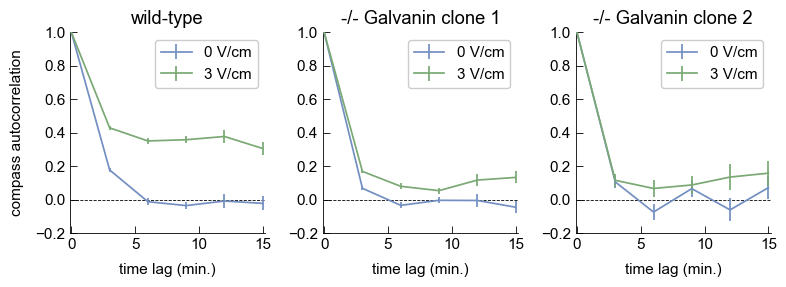

In [13]:
f, ax = plt.subplots(1,3, figsize = (8,3))

for g, d in df_angle_E_3.groupby(['celltype', 'E_V_cm']):
    if g[0] != 'dHL60KW':
        continue
    if g[1] == 1:
        continue
    if g[1] == 5:
        continue
    
    acf_all = np.zeros(8)
    for g_, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
        d_ = d_.sort_values('interval')
        y = d_.cos_angle.values

        # need each array to be same length (take only full length 
        # tracks, or ones missing an interval)
        if len(y) > 8:
            y = y[:8]
        if len(y) != 8:
            continue

        acf = non_overlapping_normalized_autocorrelation(y)  

        acf_all = np.vstack([acf_all, acf])

        
    acf_all = acf_all[1:,:]
    print(np.mean(acf_all, axis =1).shape)
    ax[0].errorbar(x = np.arange(6)*3,
                   y = np.mean(acf_all[:,:6], axis =0), 
                   yerr = np.var(acf_all[:,:6], axis =0)/np.sqrt(len(acf_all[:,:6])),
                   label = ''.join([str(g[1]),' V/cm']), zorder = 10, lw = 1.25)
    
ax[0].legend()
ax[0].set_title('wild-type')



for g, d in df_angle_E_3.groupby(['celltype', 'E_V_cm']):
    if g[0] != 'dHL60TMEM154KO-clone1':
        continue
    if g[1] == 1:
        continue
    if g[1] == 5:
        continue
        
    acf_all = np.zeros(8)

    
    for g_, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
        d_ = d_.sort_values('interval')
        y = d_.cos_angle.values
        
        # need each array to be same length (take only full length 
        # tracks, or ones missing an interval)
        if len(y) > 8:
            y = y[:8]
        if len(y) != 8:
            continue
            
        acf = non_overlapping_normalized_autocorrelation(y)  

        acf_all = np.vstack([acf_all, acf])

        
    acf_all = acf_all[1:,:]
    print(np.mean(acf_all, axis =1).shape)
    ax[1].errorbar(x = np.arange(6)*3,
                   y = np.mean(acf_all[:,:6], axis =0), 
                   yerr = np.var(acf_all[:,:6], axis =0)/np.sqrt(len(acf_all[:,:6])),
                   label = ''.join([str(g[1]),' V/cm']), zorder = 10, lw = 1.25)
    
ax[1].legend()
ax[1].set_title('-/- Galvanin clone 1')


for g, d in df_angle_E_3.groupby(['celltype', 'E_V_cm']):
    if g[0] != 'dHL60TMEM154KO-clone12':
        continue
    if g[1] == 1:
        continue
    if g[1] == 5:
        continue
        
    acf_all = np.zeros(8)
    
    for g_, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
        d_ = d_.sort_values('interval')
        y = d_.cos_angle.values

        # need each array to be same length (take only full length 
        # tracks, or ones missing an interval)
        if len(y) > 8:
            y = y[:8]
        if len(y) != 8:
            continue

        acf = non_overlapping_normalized_autocorrelation(y) 

        acf_all = np.vstack([acf_all, acf])

        
    acf_all = acf_all[1:,:]
    print(np.mean(acf_all, axis =1).shape)
    ax[2].errorbar(x = np.arange(6)*3,
                   y = np.mean(acf_all[:,:6], axis =0), 
                   yerr = np.std(acf_all[:,:6], axis =0)/np.sqrt(len(acf_all[:,:6])),
                   label = ''.join([str(g[1]),' V/cm']), zorder = 10, lw = 1.25)
    
ax[2].legend()
ax[2].set_title('-/- Galvanin clone 2')

for ax_ in ax:
    ax_.set_xlim(-0.1, 5*3+0.2)
    ax_.set_xticks([0,5,10,15])
    ax_.set_ylim(-0.2, 1)
    ax_.hlines(0,0,6*3, zorder = 0, color = 'k', linestyle = '--')
    ax_.set_xlabel('time lag (min.)')
ax[0].set_ylabel('compass autocorrelation')

plt.tight_layout()
# plt.savefig('../../figures/Figure3_supp_autocorr_KO-clones.pdf')

## Plot of projected speed histograms


0
('dHL60KW', 0)
wild-type
num. cells:  679
num. intervals:  5694
('dHL60TMEM154KO-clone1', 0)
knockout
num. cells:  884
num. intervals:  7401
('dHL60TMEM154KO-clone12', 0)
rescue
num. cells:  229
num. intervals:  1992
1
3
('dHL60KW', 3)
wild-type
num. cells:  601
num. intervals:  5032
('dHL60TMEM154KO-clone1', 3)
knockout
num. cells:  855
num. intervals:  7320
('dHL60TMEM154KO-clone12', 3)
rescue
num. cells:  197
num. intervals:  1665
5


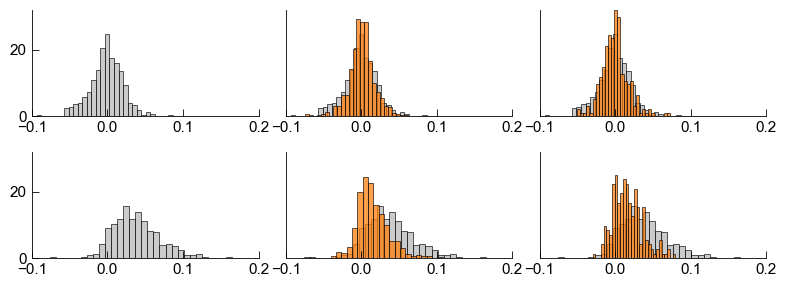

In [14]:
fig, axs = plt.subplots(nrows=2, ncols = 3, figsize = (8, 3))

count = 0
for E, df_temp in df.groupby('E_V_cm'):
    print(E)
    if E == 5:
        continue
    if E == 1:
        continue
        
    count_int_kw = 0
    count_cell_kw = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60KW'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_kw = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_kw += 1
                dot_kw = np.append(dot_kw,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_kw += 1
    print('wild-type')
    print('num. cells: ', count_cell_kw)
    print('num. intervals: ', count_int_kw)
    
    count_int_ko = 0
    count_cell_ko = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone1'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_ko = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko += 1
                dot_ko = np.append(dot_ko,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_ko += 1
            
    print('knockout')
    print('num. cells: ', count_cell_ko)
    print('num. intervals: ', count_int_ko)
    count_int_res = 0
    count_cell_res = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone12'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)
        
        dot_res = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_res += 1
                dot_res = np.append(dot_res,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))

            count_cell_res += 1
    print('rescue')
    print('num. cells: ', count_cell_res)
    print('num. intervals: ', count_int_res)              
            
    if count == 0:

        axs[count, 0].hist(dot_kw/(3.0*60), 30, density=True, 
                       alpha=0.75, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')
        
        axs[count, 1].hist(dot_kw/(3.0*60), 30, density=True, 
                       alpha=0.75, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')

        axs[count, 2].hist(dot_kw/(3.0*60), 30, density=True, 
                       alpha=0.75, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')

        axs[count, 1].hist(dot_ko/(3.0*60), 30, density=True, 
                       alpha=0.75, color = color_dict[ko1], linewidth=0.6, edgecolor='black', label = 'galvanin\nknockout - clone1')

        axs[count, 2].hist(dot_res/(3.0*60), 30, density=True, 
                       alpha=0.75, color = color_dict[ko1], linewidth=0.6, edgecolor='black', label = 'galvanin\nknockout - clone2')
    else:
        axs[count, 0].hist(dot_kw/(3.0*60), 30, density=True, 
                   alpha=0.75, color = color_dict[wt],edgecolor='black',  linewidth=0.6)
        
        axs[count, 1].hist(dot_kw/(3.0*60), 30, density=True, 
                   alpha=0.75, color = color_dict[wt],edgecolor='black',  linewidth=0.6)

        axs[count, 2].hist(dot_kw/(3.0*60), 30, density=True, 
                   alpha=0.75, color = color_dict[wt],edgecolor='black',  linewidth=0.6)

        axs[count, 1].hist(dot_ko/(3.0*60), 30, density=True, 
                       alpha=0.75, color = color_dict[ko1],edgecolor='black',  linewidth=0.6)

        axs[count, 2].hist(dot_res/(3.0*60), 30, density=True, 
                       alpha=0.75, color = color_dict[ko1],edgecolor='black',  linewidth=0.6)
    
#     axs[count,1].set_title(str(E) + ' V/cm')
#     axs[count,0].set_ylabel('probability')
    count += 1


# axs[0, 0].set_title('\nwild-type')
# axs[0, 1].set_title('\ngalvanin knockout')
# axs[0, 2].set_title('galvanin knockout +\ngalvanin-GFP')

# axs[2, 0].set_xlabel(r'directed speed [$\mu$m/min]')
# axs[2, 1].set_xlabel(r'directed speed [$\mu$m/min]')
# axs[2, 2].set_xlabel(r'directed speed [$\mu$m/min]')


axs = axs.ravel()
for ax_ in axs:
    ax_.set_xlim(-0.1,0.2)
    ax_.set_ylim(0,32)
    ax_.set_yticks([0,20])

    
for ax_ind in [1,2,4,5]:
    axs[ax_ind].yaxis.set_visible(False)
        
plt.tight_layout()

# plt.savefig('../../figures/Figure3_supp_directedspeed_KO-clones_.pdf')

In [17]:
## Now repeat with equal bins

In [18]:
# Determine the fixed bin width
bin_width = 0.006  # Adjust this value to your desired bin width

# Determine the common range for all histograms
data_min = min(np.min(dot_kw/(3.0*60)), np.min(dot_ko/(3.0*60)),  np.min(dot_res/(3.0*60))) 
data_max = max(np.max(dot_kw/(3.0*60)), np.max(dot_ko/(3.0*60)),  np.max(dot_res/(3.0*60)))

# Create bin edges based on the fixed bin width
bins = np.arange(data_min, data_max + bin_width, bin_width)

0
('dHL60KW', 0)
wild-type
num. cells:  679
num. intervals:  5694
('dHL60TMEM154KO-clone1', 0)
knockout
num. cells:  884
num. intervals:  7401
('dHL60TMEM154KO-clone12', 0)
rescue
num. cells:  229
num. intervals:  1992
1
3
('dHL60KW', 3)
wild-type
num. cells:  601
num. intervals:  5032
('dHL60TMEM154KO-clone1', 3)
knockout
num. cells:  855
num. intervals:  7320
('dHL60TMEM154KO-clone12', 3)
rescue
num. cells:  197
num. intervals:  1665
5


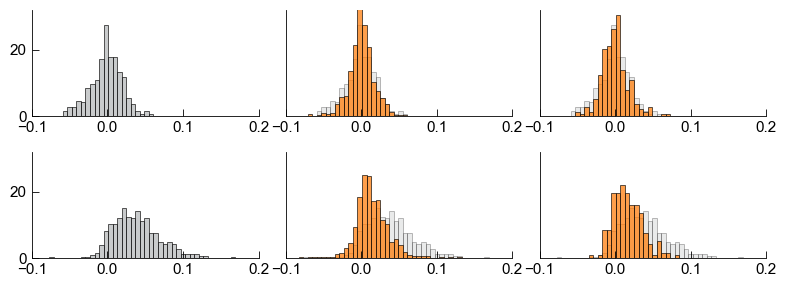

In [19]:
fig, axs = plt.subplots(nrows=2, ncols = 3, figsize = (8, 3))

count = 0
for E, df_temp in df.groupby('E_V_cm'):
    print(E)
    if E == 5:
        continue
    if E == 1:
        continue
        
    count_int_kw = 0
    count_cell_kw = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60KW'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_kw = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_kw += 1
                dot_kw = np.append(dot_kw,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_kw += 1
    print('wild-type')
    print('num. cells: ', count_cell_kw)
    print('num. intervals: ', count_int_kw)
    
    count_int_ko = 0
    count_cell_ko = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone1'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_ko = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko += 1
                dot_ko = np.append(dot_ko,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_ko += 1
            
    print('knockout')
    print('num. cells: ', count_cell_ko)
    print('num. intervals: ', count_int_ko)
    count_int_res = 0
    count_cell_res = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone12'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)
        
        dot_res = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_res += 1
                dot_res = np.append(dot_res,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))

            count_cell_res += 1
    print('rescue')
    print('num. cells: ', count_cell_res)
    print('num. intervals: ', count_int_res)              
            
    if count == 0:

        axs[count, 0].hist(dot_kw/(3.0*60), bins, density=True, 
                       alpha=0.75, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')
        
        axs[count, 1].hist(dot_kw/(3.0*60), bins, density=True, 
                       alpha=0.3, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')

        axs[count, 2].hist(dot_kw/(3.0*60), bins, density=True, 
                       alpha=0.3, color = color_dict[wt], linewidth=0.6,edgecolor='black',  label = 'wild-type')

        axs[count, 1].hist(dot_ko/(3.0*60), bins, density=True, 
                       alpha=0.75, color = color_dict[ko1], linewidth=0.6, edgecolor='black', label = 'galvanin\nknockout - clone1')

        axs[count, 2].hist(dot_res/(3.0*60), bins, density=True, 
                       alpha=0.75, color = color_dict[ko1], linewidth=0.6, edgecolor='black', label = 'galvanin\nknockout - clone2')
    else:
        axs[count, 0].hist(dot_kw/(3.0*60), bins, density=True, 
                   alpha=0.75, color = color_dict[wt],edgecolor='black',  linewidth=0.6)
        
        axs[count, 1].hist(dot_kw/(3.0*60), bins, density=True, 
                   alpha=0.3, color = color_dict[wt],edgecolor='black',  linewidth=0.6)

        axs[count, 2].hist(dot_kw/(3.0*60), bins, density=True, 
                   alpha=0.3, color = color_dict[wt],edgecolor='black',  linewidth=0.6)

        axs[count, 1].hist(dot_ko/(3.0*60), bins, density=True, 
                       alpha=0.75, color = color_dict[ko1],edgecolor='black',  linewidth=0.6)

        axs[count, 2].hist(dot_res/(3.0*60), bins, density=True, 
                       alpha=0.75, color = color_dict[ko1],edgecolor='black',  linewidth=0.6)
    
#     axs[count,1].set_title(str(E) + ' V/cm')
#     axs[count,0].set_ylabel('probability')
    count += 1


# axs[0, 0].set_title('\nwild-type')
# axs[0, 1].set_title('\ngalvanin knockout')
# axs[0, 2].set_title('galvanin knockout +\ngalvanin-GFP')

# axs[2, 0].set_xlabel(r'directed speed [$\mu$m/min]')
# axs[2, 1].set_xlabel(r'directed speed [$\mu$m/min]')
# axs[2, 2].set_xlabel(r'directed speed [$\mu$m/min]')


axs = axs.ravel()
for ax_ in axs:
    ax_.set_xlim(-0.1,0.2)
    ax_.set_ylim(0,32)
    ax_.set_yticks([0,20])

    
for ax_ind in [1,2,4,5]:
    axs[ax_ind].yaxis.set_visible(False)
        
plt.tight_layout()

# plt.savefig('../../figures/Figure3_supp_directedspeed_KO-clones_.pdf')

### Statistics to compare mean values

In [29]:
print('0 mV/mm condition')

count = 0
for E, df_temp in df.groupby('E_V_cm'):
    if E != 0:
        continue
         
    count_int_kw = 0
    count_cell_kw = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60KW'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_kw = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_kw += 1
                dot_kw = np.append(dot_kw,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_kw += 1
    print('wild-type')
    print('num. cells: ', count_cell_kw)
    print('num. intervals: ', count_int_kw)
    
    count_int_ko1 = 0
    count_cell_ko1 = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone1'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_ko1 = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko1 += 1
                dot_ko1 = np.append(dot_ko1,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_ko1 += 1
            
    print('knockout')
    print('num. cells: ', count_cell_ko1)
    print('num. intervals: ', count_int_ko1)
    
    count_int_ko2 = 0
    count_cell_ko2 = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone12'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)
        
        dot_ko2 = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko2 += 1
                dot_ko2 = np.append(dot_ko2,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))

            count_cell_ko2 += 1
            
    print('rescue')
    print('num. cells: ', count_cell_ko2)
    print('num. intervals: ', count_int_ko2)     



df_treat = dot_ko1
df_control = dot_kw
print('KO clone 1 versus wild-type: ', mannwhitneyu(df_treat, df_control))   

df_treat = dot_ko2
df_control = dot_kw
print('KO clone 12 versus wild-type: ', mannwhitneyu(df_treat, df_control))  

0 mV/mm condition
('dHL60KW', 0)
wild-type
num. cells:  679
num. intervals:  5694
('dHL60TMEM154KO-clone1', 0)
knockout
num. cells:  884
num. intervals:  7401
('dHL60TMEM154KO-clone12', 0)
rescue
num. cells:  229
num. intervals:  1992
KO clone 1 versus wild-type:  MannwhitneyuResult(statistic=313360.0, pvalue=0.13436938902961743)
KO clone 12 versus wild-type:  MannwhitneyuResult(statistic=77736.0, pvalue=0.9979076317263039)


In [28]:
print('300 mV/mm condition')

count = 0
for E, df_temp in df.groupby('E_V_cm'):
    if E != 3:
        continue
         
    count_int_kw = 0
    count_cell_kw = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60KW'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_kw = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_kw += 1
                dot_kw = np.append(dot_kw,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_kw += 1
    print('wild-type')
    print('num. cells: ', count_cell_kw)
    print('num. intervals: ', count_int_kw)
    
    count_int_ko1 = 0
    count_cell_ko1 = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone1'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)

        dot_ko1 = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko1 += 1
                dot_ko1 = np.append(dot_ko1,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))
                    
            count_cell_ko1 += 1
            
    print('knockout')
    print('num. cells: ', count_cell_ko1)
    print('num. intervals: ', count_int_ko1)
    
    count_int_ko2 = 0
    count_cell_ko2 = 0
    for g, d in df_temp[df_temp.celltype == 'dHL60TMEM154KO-clone12'].groupby(['celltype',  'E_V_cm'],  sort=False):
        print(g)
        
        dot_ko2 = []
        for cell, d_ in d.groupby(['date', 'trial', 'user', 'cell']):
            if len(d_.frame.unique()) > 10:
                tot = 0
                for t in np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]:
                    vec_t1 = [d_[d_.frame == t].x.values[0] - d_[d_.frame == t-3].x.values[0],
                              d_[d_.frame == t].y.values[0] - d_[d_.frame == t-3].y.values[0]]
                    tot += vec_t1[0]
                    count_int_ko2 += 1
                dot_ko2 = np.append(dot_ko2,tot/len(np.arange(d_.frame.min(),d_.frame.max(), 3)[1:]))

            count_cell_ko2 += 1
            
    print('rescue')
    print('num. cells: ', count_cell_ko2)
    print('num. intervals: ', count_int_ko2)     


df_treat = dot_ko1
df_control = dot_kw
print('KO clone 1 versus wild-type: ', mannwhitneyu(df_treat, df_control))   

df_treat = dot_ko2
df_control = dot_kw
print('KO clone 12 versus wild-type: ', mannwhitneyu(df_treat, df_control))  

300 mV/mm condition
('dHL60KW', 3)
wild-type
num. cells:  601
num. intervals:  5032
('dHL60TMEM154KO-clone1', 3)
knockout
num. cells:  855
num. intervals:  7320
('dHL60TMEM154KO-clone12', 3)
rescue
num. cells:  197
num. intervals:  1665
KO clone 1 versus wild-type:  MannwhitneyuResult(statistic=133262.0, pvalue=3.0120465745316896e-55)
KO clone 12 versus wild-type:  MannwhitneyuResult(statistic=32530.0, pvalue=2.1372806969034213e-21)
